# VEHICLE INSURANCE FRAUD DETECTION

In [123]:
# Import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, RocCurveDisplay, precision_score, recall_score, accuracy_score, roc_auc_score, classification_report

# Igonore warnings
import warnings
warnings.filterwarnings('ignore')

# Set style sheet for plots
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seed
random_seed = 49

In [124]:
# Read the csv file
df = pd.read_csv('data/insurance_fraud.csv')
df.head(7)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision
5,Oct,4,Friday,Honda,Urban,Wednesday,Nov,1,Male,Single,...,5 years,21 to 25,No,No,External,3 to 5,no change,1 vehicle,1994,Collision
6,Feb,1,Saturday,Honda,Urban,Monday,Feb,3,Male,Married,...,7 years,36 to 40,No,No,External,1 to 2,no change,1 vehicle,1994,Collision


In [125]:
# check how many rows and columns
df.shape

(15420, 33)

In [126]:
# check for duplicated observations
df.duplicated().sum()

0

In [127]:
# Check for missing values
df.isna().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

In [128]:
# Rename the Fraud Found column
df = df.rename({'FraudFound_P': 'FraudFound'}, axis=1)

The dataset has 15420 observations with 33 columns. No missing values. No duplicates

## EDA

### Distribution of Target Variable

In [129]:
# check the proportion of the target variable (FraudFound)
df['FraudFound'].value_counts()

FraudFound
0    14497
1      923
Name: count, dtype: int64

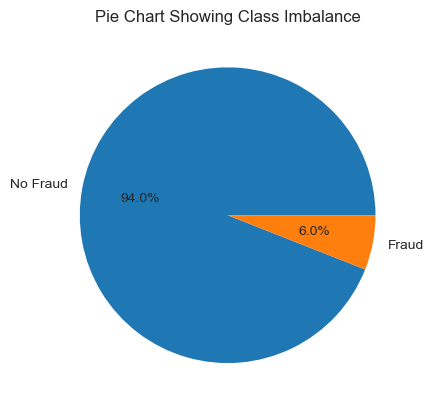

In [130]:
# Visualize the proportion with a pie chart
plt.pie(df.FraudFound.value_counts(), labels=["No Fraud", "Fraud"], autopct='%1.1f%%')
plt.title('Pie Chart Showing Class Imbalance')
plt.show()

* The target variable FraudFound is highly imbalanced, with 94% non-fraud cases and only 6% fraud cases.
* This imbalance will impact model training, so we will need to handle the class imbalance using sampling techniques, class weights, etc.
* Accuarcy would not be enough to evaluate the model, so we will focus on recall, ROC-AUC, and F1 Score

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound            15420 non-null

### Summary statistics of numeric features

In [132]:
# check summary statistics for numerical columns
numeric_cols = df.select_dtypes(include='int').columns
df[numeric_cols].describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


Based on these summary statistics, we can tell that:
* The mean age of policyholders is around 40, and the standard deviation is 13.5 which indicates that there is a diverse range of ages of policyholders.
* The min age is 0, and the max age is 80, this might indicate some outliers are present, will need more investigation
* There is a unique policy number for each claim, meaning we might not need the column, similar with RepNumber
* Driver Rating is from 1 to 4, it should be treated as categorical
* The data contains insurance claims between 1994 and 1996.

### Distribution of numeric features

In [133]:
numeric_cols

Index(['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'FraudFound',
       'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Year'],
      dtype='object')

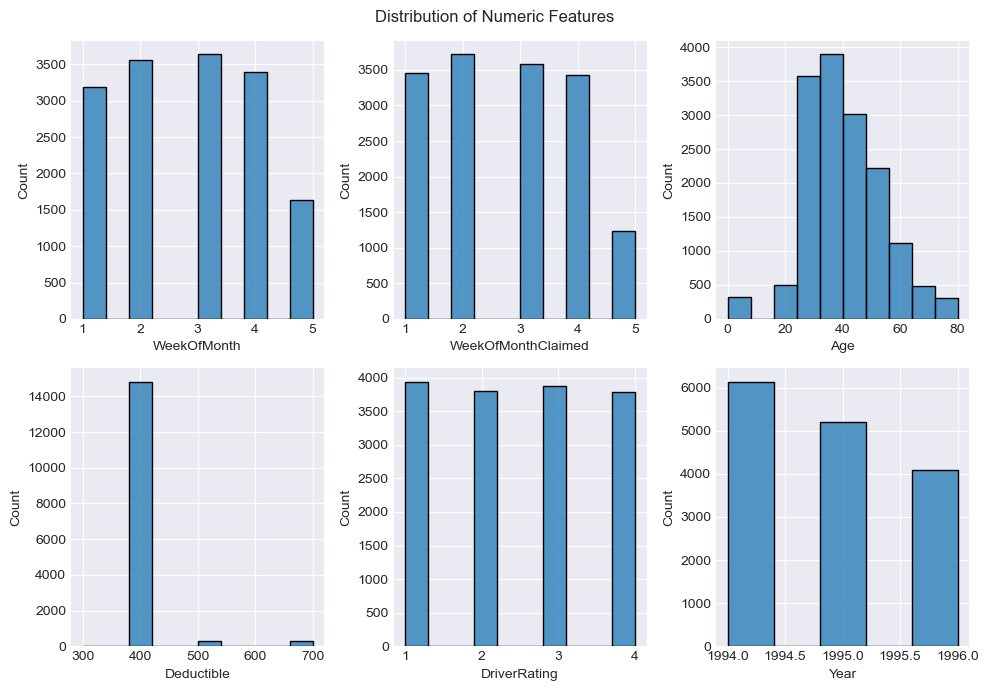

In [134]:
# plot the distribution of the numeric features
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,7))
sns.histplot(data=df, x='WeekOfMonth', bins=10, ax=ax[0,0])
sns.histplot(data=df, x='WeekOfMonthClaimed', bins=10, ax=ax[0,1])
sns.histplot(data=df, x='Age', bins=10, ax=ax[0,2])

sns.histplot(data=df, x='Deductible', bins=10, ax=ax[1,0])
sns.histplot(data=df, x='DriverRating', bins=10, ax=ax[1,1])
sns.histplot(data=df, x='Year', bins=5, ax=ax[1,2])

# Add a centered title
fig.suptitle("Distribution of Numeric Features")
plt.tight_layout()

* WeekOfMonth and WeekOfMonthClaimed: These have similar distributions,
  
  indicating that incidents and claims are distributed evenly across weeks.
* Age: The distribution is skewed towards younger ages, with fewer older policyholders.
* Deductible: Majority is on 400, should be categorical.
* DriverRating: A uniform-like distribution with values from 1 to 4.
* Year: Most cases occured in 1994, should be categorical.

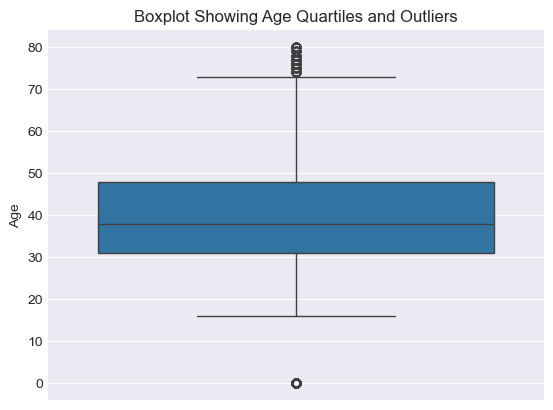

In [135]:
# Visualize the Distribution of Age 
sns.boxplot(data=df, y='Age')
plt.title('Boxplot Showing Age Quartiles and Outliers')
plt.show()

The boxplot shows some potential outliers at 0 and above ~72

### Distribution of Categorical features

In [136]:
categorical_cols = df.select_dtypes(include="object").columns
categorical_cols

Index(['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed',
       'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType',
       'VehicleCategory', 'VehiclePrice', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
       'BasePolicy'],
      dtype='object')

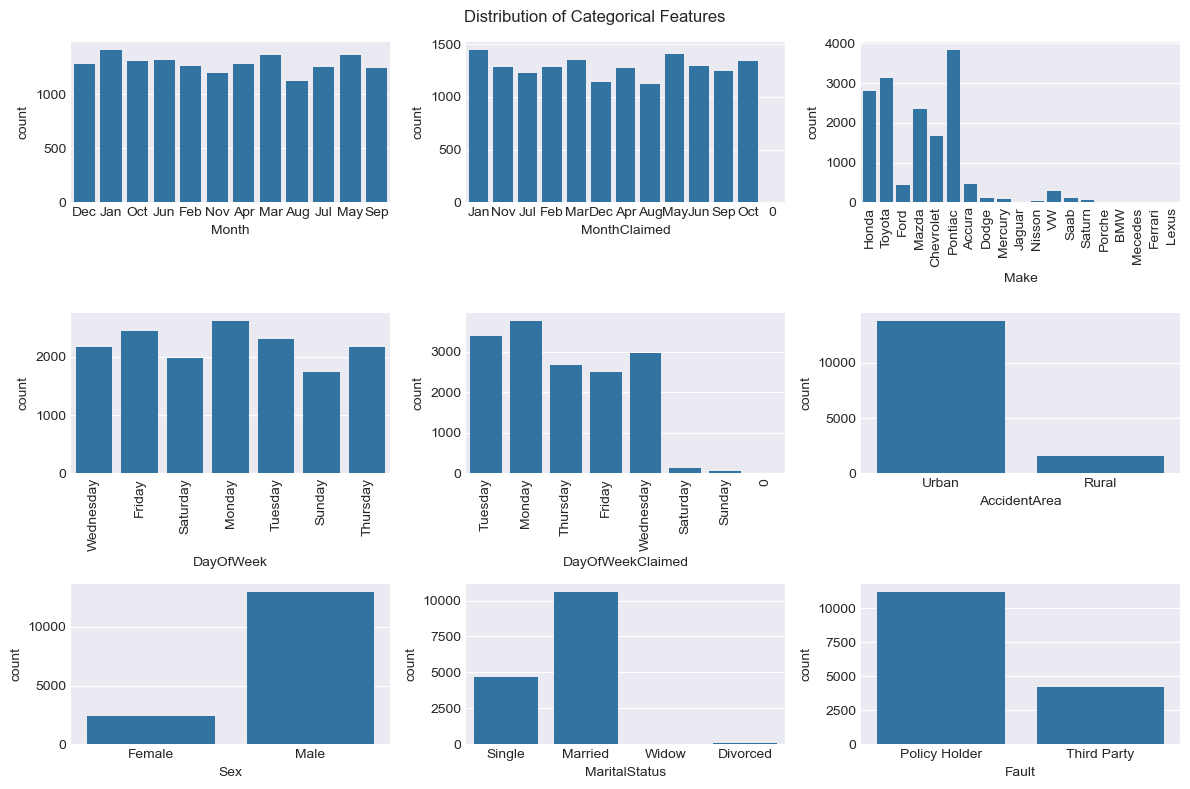

In [137]:
# plot the distribution of the categorical features
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,8))
sns.countplot(data=df, x ='Month', ax=ax[0,0])
sns.countplot(data=df, x ='MonthClaimed', ax=ax[0,1])
sns.countplot(data=df, x ='Make', ax=ax[0,2])
# rotate the xticks to 90 degrees
ax[0,2].tick_params(axis='x', rotation=90)

sns.countplot(data=df, x ='DayOfWeek', ax=ax[1,0])
# rotate the xticks to 90 degrees
ax[1,0].tick_params(axis='x', rotation=90)

sns.countplot(data=df, x ='DayOfWeekClaimed', ax=ax[1,1])
# rotate the xticks to 90 degrees
ax[1,1].tick_params(axis='x', rotation=90)

sns.countplot(data=df, x ='AccidentArea', ax=ax[1,2])
sns.countplot(data=df, x ='Sex', ax=ax[2,0])
sns.countplot(data=df, x ='MaritalStatus', ax=ax[2,1])
sns.countplot(data=df, x ='Fault', ax=ax[2,2])

# Add a centered title
fig.suptitle("Distribution of Categorical Features")
plt.tight_layout()
fig.savefig('Distribution of Categorical Features.png', bbox_inches='tight')
plt.show()

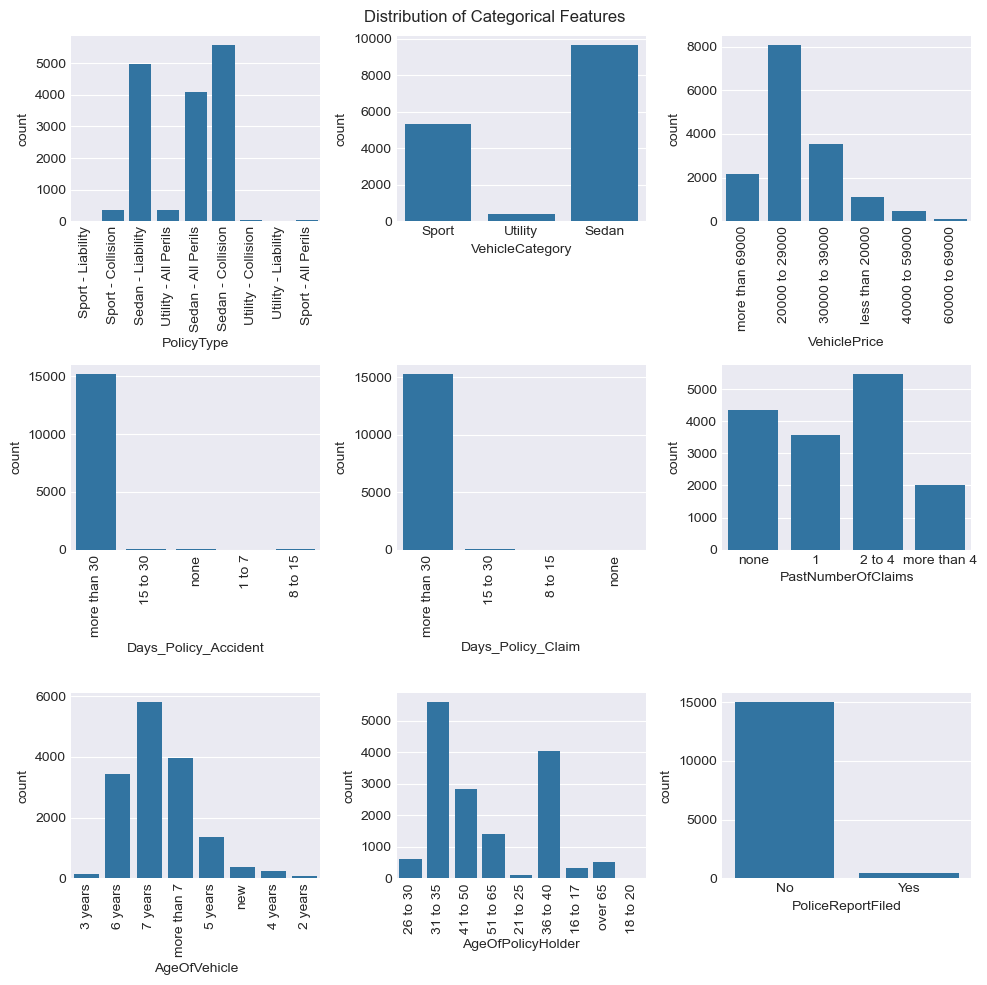

In [138]:
# plot the distribution of the categorical features
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
sns.countplot(data=df, x ='PolicyType', ax=ax[0,0])
# rotate the xticks to 90 degrees
ax[0,0].tick_params(axis='x', rotation=90)
sns.countplot(data=df, x ='VehicleCategory', ax=ax[0,1])
sns.countplot(data=df, x ='VehiclePrice', ax=ax[0,2])
# rotate the xticks to 90 degrees
ax[0,2].tick_params(axis='x', rotation=90)

sns.countplot(data=df, x ='Days_Policy_Accident', ax=ax[1,0])
# rotate the xticks to 90 degrees
ax[1,0].tick_params(axis='x', rotation=90)

sns.countplot(data=df, x ='Days_Policy_Claim', ax=ax[1,1])
# rotate the xticks to 90 degrees
ax[1,1].tick_params(axis='x', rotation=90)

sns.countplot(data=df, x ='PastNumberOfClaims', ax=ax[1,2])

sns.countplot(data=df, x ='AgeOfVehicle', ax=ax[2,0])
# rotate the xticks to 90 degrees
ax[2,0].tick_params(axis='x', rotation=90)
sns.countplot(data=df, x ='AgeOfPolicyHolder', ax=ax[2,1])
# rotate the xticks to 90 degrees
ax[2,1].tick_params(axis='x', rotation=90)
sns.countplot(data=df, x ='PoliceReportFiled', ax=ax[2,2])

# Add a centered title
fig.suptitle("Distribution of Categorical Features")
plt.tight_layout()
fig.savefig('Distribution of Categorical Features.png', bbox_inches='tight')
plt.show()

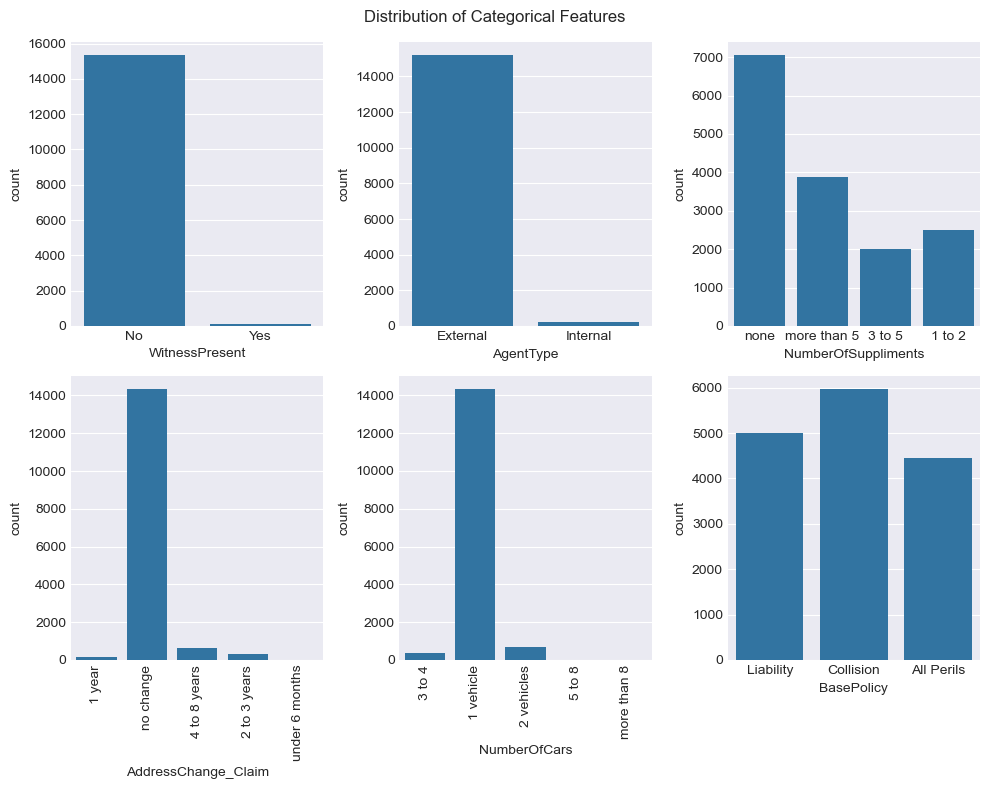

In [139]:
# plot the distribution of the categorical features
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,8))
sns.countplot(data=df, x ='WitnessPresent', ax=ax[0,0])
sns.countplot(data=df, x ='AgentType', ax=ax[0,1])
sns.countplot(data=df, x ='NumberOfSuppliments', ax=ax[0,2])

sns.countplot(data=df, x ='AddressChange_Claim', ax=ax[1,0])
# rotate the xticks to 90 degrees
ax[1,0].tick_params(axis='x', rotation=90)
sns.countplot(data=df, x ='NumberOfCars', ax=ax[1,1])
# rotate the xticks to 90 degrees
ax[1,1].tick_params(axis='x', rotation=90)
sns.countplot(data=df, x ='BasePolicy', ax=ax[1,2])

# Add a centered title
fig.suptitle("Distribution of Categorical Features")
plt.tight_layout()
fig.savefig('Distribution of Categorical Features.png', bbox_inches='tight')
plt.show()

* The distribution of claims in Month, MonthClaimed, DayOfWeek, and DayOfWeekClamied appear relatively uniform, indicating that there is no seasonal trend
* Make: Pontiac, Honda, and Toyota cars have the highest number of claims
* AccidentArea: There are much more insurance claims in Urban areas than in Rural Areas
* Sex: A vast majority of the claims were filed by Men
* Marital Status: Married people, then Single people filed the most number of insurcance claims
* Fault: Most of the Insurance claims were filed by the Policy Holder, rather than a Third Party.
* PolicyType and VehicleCategory: Sedans with any of the three base policies have the most number of claims.
* Days_Policy_Accident and Days_Policy_Claim: Mostly “more than 30” days, with rare occurrences of other categories.
* NumberOfSuppliments, NumberOfCars, and AddressChange_Claim: Show concentration in specific categories.
* DayOfWeekClaimed and MonthClaimed: Each contains a "0" value, which should be removed
* WitnessPresent and PoliceReportFiled: The majority is "No"

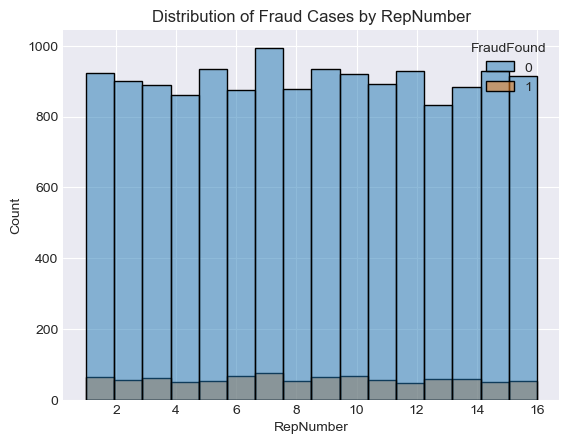

In [140]:
sns.histplot(data=df, x='RepNumber', bins=16, hue='FraudFound', alpha=0.5)
plt.title("Distribution of Fraud Cases by RepNumber")
plt.show()

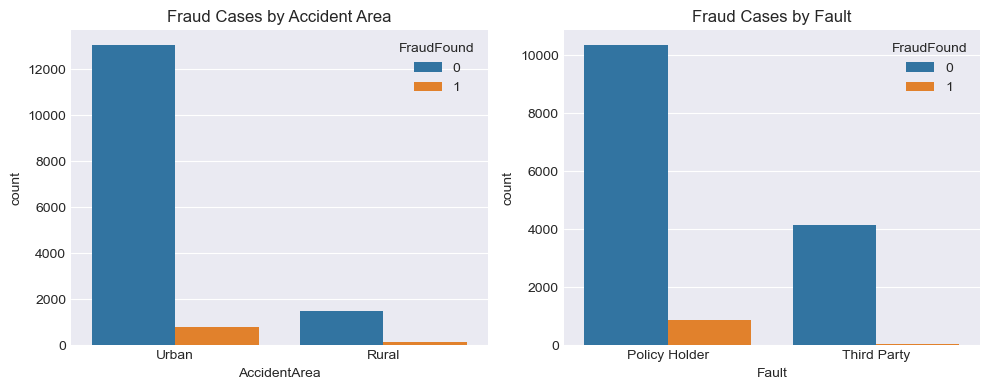

In [141]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
sns.countplot(data=df, x='AccidentArea', hue='FraudFound', ax=ax[0])
sns.countplot(data=df, x='Fault', hue='FraudFound', ax=ax[1])

ax[0].set_title('Fraud Cases by Accident Area')
ax[1].set_title('Fraud Cases by Fault')

plt.tight_layout()
plt.show()

* A majority of the fraudulent claims happen in Urban Areas, but this could just be because there is a higher portion of claims peroid.
* Most fraudulent claims are caused by the Policy Holder, but similar to the accident area, it might just be because more Policy Holders file claims than the third parties involved.

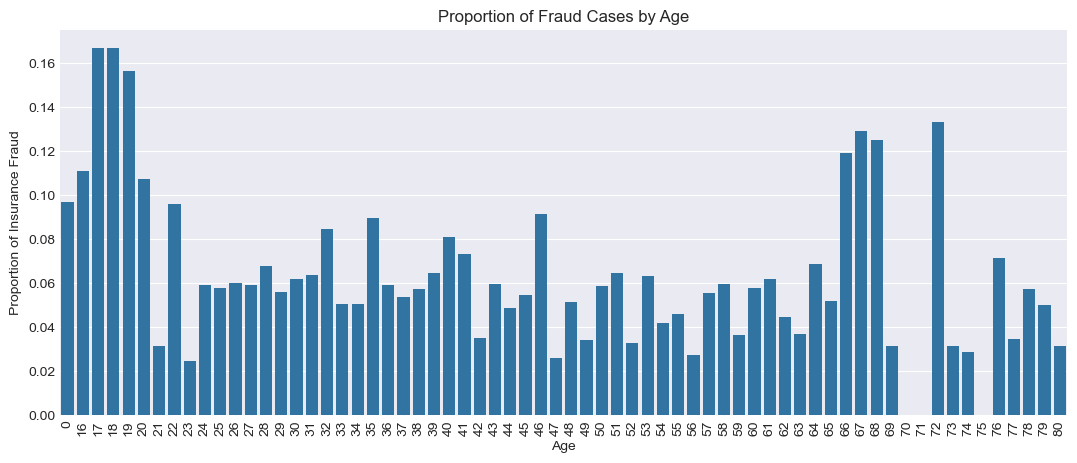

In [142]:
# plot relationship between Age and FraudFound
plt.figure(figsize=(13,5))
sns.barplot(data=df, x="Age", y="FraudFound", ci=None)
plt.xticks(rotation=90)
plt.ylabel("Proportion of Insurance Fraud")
plt.title("Proportion of Fraud Cases by Age")
plt.show()

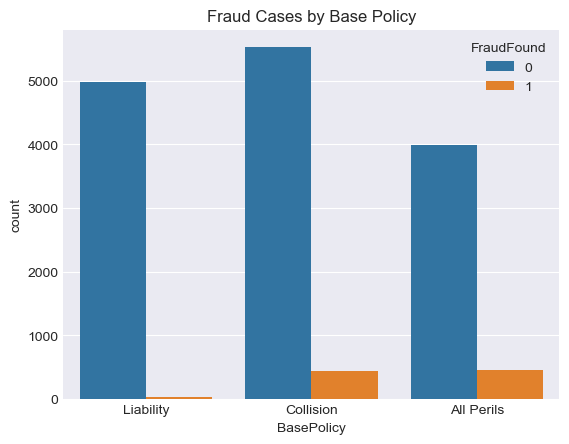

In [143]:
sns.countplot(data=df, hue='FraudFound', x='BasePolicy')
plt.title('Fraud Cases by Base Policy')
plt.show()

In [144]:
df.groupby(by='BasePolicy')['FraudFound'].value_counts()

BasePolicy  FraudFound
All Perils  0             3997
            1              452
Collision   0             5527
            1              435
Liability   0             4973
            1               36
Name: count, dtype: int64

* Liability policies have a high number of claims but the fraudulent ones are extremely low.
* All Perils policies have the lowest number of claims but they have the most fraudulent cases.
* All Perils and Collision policies might be associated with a higher risk of fraud.

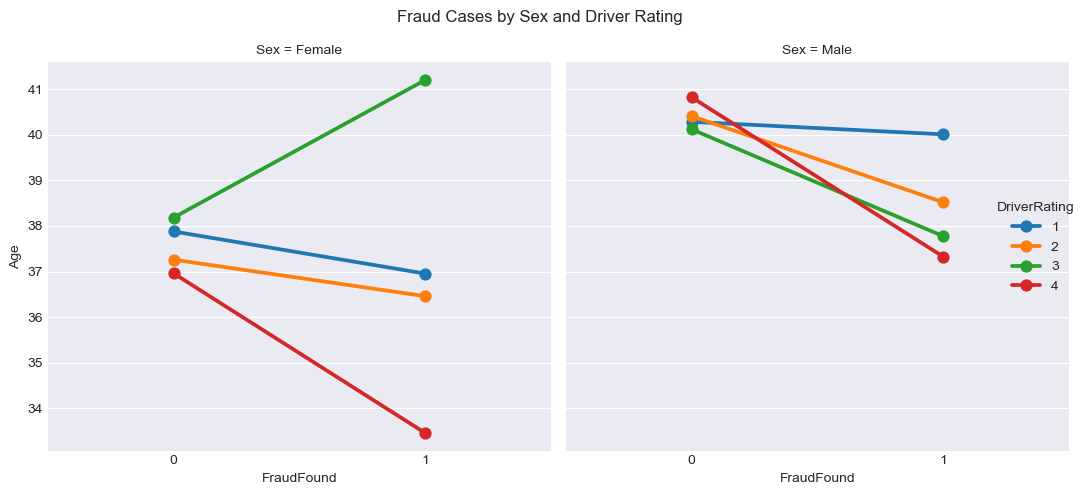

In [145]:
sns.catplot(kind='point', data=df, y='Age', hue='DriverRating', x='FraudFound', col='Sex', ci=None, palette='tab10')
plt.suptitle("Fraud Cases by Sex and Driver Rating")
plt.tight_layout()
plt.show()

* The relationship between age and driver rating appears to differ between male and female policyholders.
* Younger female drivers tend to have higher driver ratings, while older female drivers have slightly lower ratings.
* For male drivers, the relationship is less clear.
* The plot suggests that younger, lower rated drivers, regardless of gender, on average, are more likely to file fraudulent claims. 

### Correlation Analysis

In [146]:
# Correlation analysis for numerical features
corr_matrix = df[numeric_cols].corr()

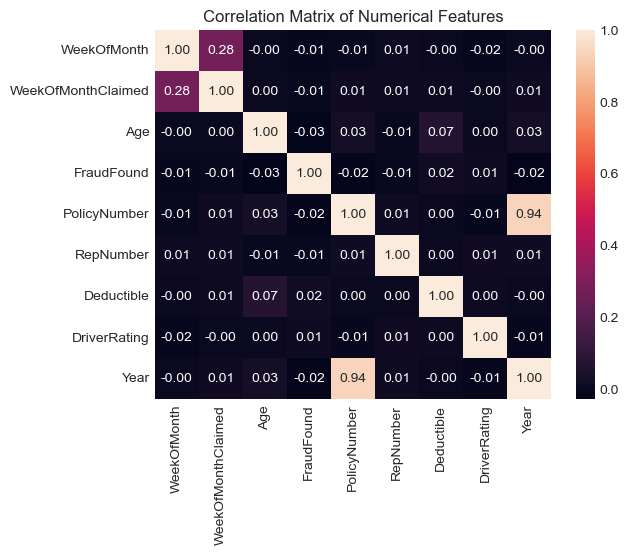

In [147]:
# Correlation analysis for numerical features
corr_matrix = df[numeric_cols].corr()
# Visualize the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="rocket", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

* Year and PolicyNumber are highly correlated (0.94), PolicyNumber will be removed because each observation is unique
* No other significant correlations, so no multicolinearity

### Handling 'zero' values

MonthClaimed and DayOfWeekClaimed have 'Zero' values

In [148]:
df.MonthClaimed.value_counts()

MonthClaimed
Jan    1446
May    1411
Mar    1348
Oct    1339
Jun    1293
Feb    1287
Nov    1285
Apr    1271
Sep    1242
Jul    1225
Dec    1146
Aug    1126
0         1
Name: count, dtype: int64

In [149]:
df.DayOfWeekClaimed.value_counts()

DayOfWeekClaimed
Monday       3757
Tuesday      3375
Wednesday    2951
Thursday     2660
Friday       2497
Saturday      127
Sunday         52
0               1
Name: count, dtype: int64

Due to the fact that its only one observation each, we're going to drop them.

In [150]:
# select the rows where neither of them is 0
df = df.query("MonthClaimed != '0' and DayOfWeekClaimed != '0'")

Handle the "0" Values on Age

In [151]:
# fill the Age 0 with the median age, not mean because of the skewed distribution
median_age = df.Age.median()
median_age

38.0

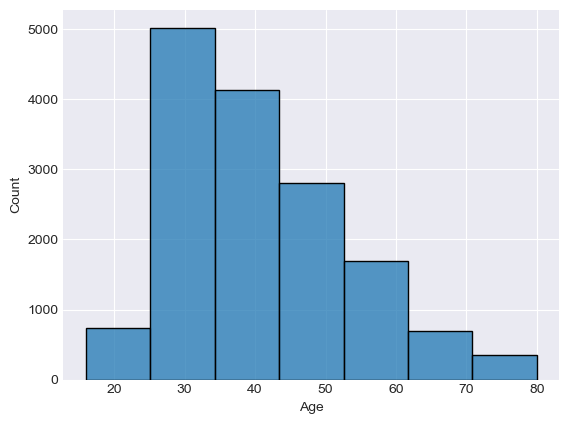

In [152]:
# fill all zero observations with the median age
df.loc[df['Age'] == 0, 'Age'] = median_age
# check the new distribution of Age
sns.histplot(data=df, x='Age', bins=7)
plt.show()

In [153]:
# save file for use in azure
df.to_csv('insurance_fraud_cleaned.csv')

### Dropping columns

In [154]:
df[['VehicleCategory', 'BasePolicy','PolicyType']].sample(7)

,VehicleCategory,BasePolicy,PolicyType
2941,Sport,Liability,Sedan - Liability
2459,Sport,Liability,Sedan - Liability
3094,Sedan,All Perils,Sedan - All Perils
2052,Sedan,Collision,Sedan - Collision
9465,Sedan,All Perils,Sedan - All Perils
7218,Sport,Liability,Sedan - Liability
11921,Utility,All Perils,Utility - All Perils


* Upon inspection, the PolicyType column is just a combination of the VehicleCategory and BasePolicy columns, making it redundant.
* Leaving it in the model could introduce multicollinearity and affect the model's performance
* To avoid this, we're going to drop the PolicyType column.

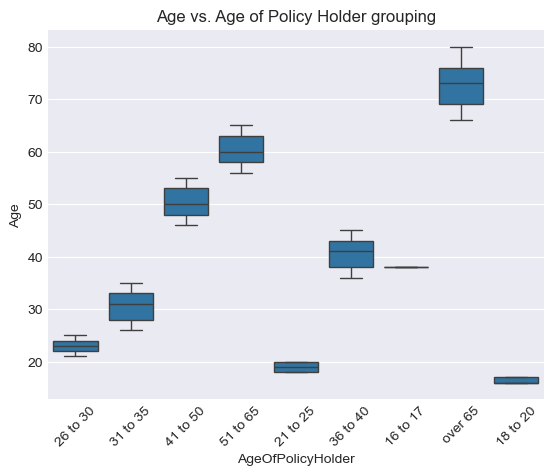

In [155]:
sns.boxplot(data=df, y='Age', x='AgeOfPolicyHolder')
plt.xticks(rotation=45)
plt.title('Age vs. Age of Policy Holder grouping')
plt.show()

Upon inspecting the AgeOfPolicyHolder column, there are some obvious errors with the grouping, so we're gonna drop it too

PolicyNumber and RepNumber: These are identifiers and don't provide predictive information.

Date-Related Columns:

Year, Month, WeekOfMonth, DayOfWeek, MonthClaimed, WeekOfMonthClaimed, and DayOfWeekClaimed: These likely don’t contribute much to fraud prediction directly. Seasonality doesn't seem to be important because there were no clear patterns by month, week, or day.

Based on these, the columns to drop are:

PolicyType, AgeOfPolicyHolder, PolicyNumber, RepNumber, Year, Month, WeekOfMonth, DayOfWeek, MonthClaimed, WeekOfMonthClaimed, and DayOfWeekClaimed

In [156]:
# drop the columns that are not needed
df = df.drop(columns=['PolicyType', 'AgeOfPolicyHolder', 'PolicyNumber', 'RepNumber', 
                      'Year', 'Month', 'WeekOfMonth', 'DayOfWeek', 'MonthClaimed',
                      'WeekOfMonthClaimed', 'DayOfWeekClaimed'])

In [157]:
df.columns

Index(['Make', 'AccidentArea', 'Sex', 'MaritalStatus', 'Age', 'Fault',
       'VehicleCategory', 'VehiclePrice', 'FraudFound', 'Deductible',
       'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'PoliceReportFiled',
       'WitnessPresent', 'AgentType', 'NumberOfSuppliments',
       'AddressChange_Claim', 'NumberOfCars', 'BasePolicy'],
      dtype='object')

## PREPROCESSING

In [158]:
# View all the unique values for each column
{col:df[col].unique() for col in df.columns}

{'Make': array(['Honda', 'Toyota', 'Ford', 'Mazda', 'Chevrolet', 'Pontiac',
        'Accura', 'Dodge', 'Mercury', 'Jaguar', 'Nisson', 'VW', 'Saab',
        'Saturn', 'Porche', 'BMW', 'Mecedes', 'Ferrari', 'Lexus'],
       dtype=object),
 'AccidentArea': array(['Urban', 'Rural'], dtype=object),
 'Sex': array(['Female', 'Male'], dtype=object),
 'MaritalStatus': array(['Single', 'Married', 'Widow', 'Divorced'], dtype=object),
 'Age': array([21, 34, 47, 65, 27, 20, 36, 38, 30, 42, 71, 52, 28, 61, 41, 32, 40,
        63, 31, 45, 60, 39, 55, 35, 44, 72, 29, 37, 59, 49, 50, 26, 48, 64,
        33, 74, 23, 25, 56, 16, 68, 18, 51, 22, 53, 46, 43, 57, 54, 69, 67,
        19, 78, 77, 75, 80, 58, 73, 24, 76, 62, 79, 70, 17, 66],
       dtype=int64),
 'Fault': array(['Policy Holder', 'Third Party'], dtype=object),
 'VehicleCategory': array(['Sport', 'Utility', 'Sedan'], dtype=object),
 'VehiclePrice': array(['more than 69000', '20000 to 29000', '30000 to 39000',
        'less than 20000', '40000 to

In [159]:
# Create a dictionary for each ordinal column as keys and their order as values
ordinal_columns = {
    'VehiclePrice': ['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000'],
    'Deductible': [300, 400, 500, 700],
    'DriverRating': [1, 2, 3, 4],
    'Days_Policy_Accident': ['none', '1 to 7', '8 to 15', '15 to 30', 'more than 30'],
    'Days_Policy_Claim': ['8 to 15', '15 to 30', 'more than 30'],
    'PastNumberOfClaims': ['none', '1', '2 to 4', 'more than 4'],
    'AgeOfVehicle': ['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7'],
    'NumberOfSuppliments': ['none', '1 to 2', '3 to 5', 'more than 5'],
    'AddressChange_Claim': ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years'],
    'NumberOfCars': ['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8'],
}

In [160]:
# Get the nominal categorical columns
nominal_columns = ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 
                   'Make', 'MaritalStatus', 'VehicleCategory', 'AgentType', 'BasePolicy']

In [161]:
# get the numeric columns
numeric_columns = ['Age']

Create a Column Transformer that:
* Scales the numeric variables using StandardScaler
* Encodes the nominal categorical variables using OneHotEncoder
* Encodes the ordinal categorical variables using OrdinalEncoder

In [162]:
# Define the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numeric_columns),
        ('ordinal', OrdinalEncoder(categories=list(ordinal_columns.values())), list(ordinal_columns.keys())),
        ('nominal', OneHotEncoder(drop='first', sparse_output=False), nominal_columns)
    ],
    remainder='passthrough'
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(), ['Age']),
                                ('ordinal',
                                 OrdinalEncoder(categories=[['less than 20000',
                                                             '20000 to 29000',
                                                             '30000 to 39000',
                                                             '40000 to 59000',
                                                             '60000 to 69000',
                                                             'more than 69000'],
                                                            [300, 400, 500,
                                                             700],
                                                            [1, 2, 3, 4],
                                                            ['none', '1 to 7',
                                                             '8 to 15',
                                                             '15 to 30',
                                                             'more than 30'],
                                                            ['8 to 15',
                                                             '15 to 30',
                                                             'more than 30'],
                                                            ['none', '1',
                                                             '2 to 4',
                                                             '...
                                 ['VehiclePrice', 'Deductible', 'DriverRating',
                                  'Days_Policy_Accident', 'Days_Policy_Claim',
                                  'PastNumberOfClaims', 'AgeOfVehicle',
                                  'NumberOfSuppliments', 'AddressChange_Claim',
                                  'NumberOfCars']),
                                ('nominal',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['AccidentArea', 'Sex', 'Fault',
                                  'PoliceReportFiled', 'WitnessPresent', 'Make',
                                  'MaritalStatus', 'VehicleCategory',
                                  'AgentType', 'BasePolicy'])])

In [163]:
# Separating target variable and features
X = df.drop('FraudFound', axis=1)
y = df['FraudFound']

In [165]:
# Split into train and test sets
# stratify parameter is set to y to make the split more balanced (split with the same ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed, stratify=y)
# Check the shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10793, 21), (4626, 21), (10793,), (4626,))

In [166]:
# fit_transform the preprocessor to the train set
X_train = preprocessor.fit_transform(X_train)
# only transform the test set
X_test = preprocessor.transform(X_test)

In [167]:
# View the encoded df
pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out()).head()

,scaler__Age,ordinal__VehiclePrice,ordinal__Deductible,ordinal__DriverRating,ordinal__Days_Policy_Accident,ordinal__Days_Policy_Claim,ordinal__PastNumberOfClaims,ordinal__AgeOfVehicle,ordinal__NumberOfSuppliments,ordinal__AddressChange_Claim,...,nominal__Make_Toyota,nominal__Make_VW,nominal__MaritalStatus_Married,nominal__MaritalStatus_Single,nominal__MaritalStatus_Widow,nominal__VehicleCategory_Sport,nominal__VehicleCategory_Utility,nominal__AgentType_Internal,nominal__BasePolicy_Collision,nominal__BasePolicy_Liability
0,-0.635407,2.0,1.0,0.0,4.0,2.0,2.0,5.0,3.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.799184,2.0,1.0,2.0,4.0,2.0,2.0,5.0,3.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.838593,5.0,1.0,1.0,4.0,2.0,3.0,7.0,2.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.838593,1.0,1.0,3.0,4.0,2.0,3.0,7.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.756704,2.0,1.0,1.0,4.0,2.0,2.0,7.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## FEATURE SELECTION

### RFECV

Recursive Feature Elimination with Cross-Validation (RFECV):

RFECV is a feature selection method that selects features by recursively removing the least important ones and evaluating model performance.
We’ll use RandomForestClassifier for RFECV to rank feature importance.

In [168]:
# Use RandomForest as the base model
rand_for = RandomForestClassifier(random_state=random_seed)

# set cross validation
scv = StratifiedKFold(5)

In [169]:
rfecv = RFECV(estimator=rand_for, step=3, cv=scv, scoring='f1', n_jobs=-1)

In [170]:
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=49), n_jobs=-1,
      scoring='f1', step=3)

In [172]:
# Lets see how many features we have left
rfecv.n_features_

27

In [173]:
# to see which features were selected
original_features = preprocessor.get_feature_names_out()
selected_features = original_features[rfecv.support_]
selected_features

array(['scaler__Age', 'ordinal__VehiclePrice', 'ordinal__Deductible',
       'ordinal__DriverRating', 'ordinal__Days_Policy_Accident',
       'ordinal__PastNumberOfClaims', 'ordinal__AgeOfVehicle',
       'ordinal__NumberOfSuppliments', 'ordinal__AddressChange_Claim',
       'ordinal__NumberOfCars', 'nominal__AccidentArea_Urban',
       'nominal__Sex_Male', 'nominal__Fault_Third Party',
       'nominal__PoliceReportFiled_Yes', 'nominal__Make_Chevrolet',
       'nominal__Make_Ford', 'nominal__Make_Honda', 'nominal__Make_Mazda',
       'nominal__Make_Pontiac', 'nominal__Make_Saab',
       'nominal__Make_Toyota', 'nominal__MaritalStatus_Married',
       'nominal__MaritalStatus_Single', 'nominal__VehicleCategory_Sport',
       'nominal__VehicleCategory_Utility',
       'nominal__BasePolicy_Collision', 'nominal__BasePolicy_Liability'],
      dtype=object)

In [174]:
# Transform the X_train and X_test
X_train_fs = rfecv.transform(X_train)
X_test_fs = rfecv.transform(X_test)

X_train_fs.shape

(10793, 27)

## Sampling Techniques to Address Class Imbalance

* SMOTE (Synthetic Minority Over-sampling Technique): This generates synthetic samples for the minority class (fraud cases).

* Random Undersampling: This reduces the size of the majority class (non-fraud cases) to match the minority class, balancing the dataset.
  
* Random Oversampling: This duplicates instances of the minority class (fraud cases), balancing the dataset.

* We apply each of these sampling techniques only to the training set to avoid data leakage into the test set 

In [214]:
# Class Imbalance before applying sampling techniques
y_train.value_counts()

FraudFound
0    10147
1      646
Name: count, dtype: int64

### SMOTE

In [176]:
# SMOTE
smote = SMOTE(random_state=random_seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train_fs, y_train)

# Balanced data after SMOTE
y_train_smote.value_counts()

FraudFound
0    10147
1    10147
Name: count, dtype: int64

### OVERSAMPLING

In [177]:
# Random Oversampling
over = RandomOverSampler(random_state=random_seed)
X_train_over, y_train_over = over.fit_resample(X_train_fs, y_train)

# Balanced data after SMOTE
y_train_smote.value_counts()

FraudFound
0    10147
1    10147
Name: count, dtype: int64

### UNDERSAMPLING

In [178]:
# Random Undersampling
under = RandomUnderSampler(random_state=random_seed)
X_train_under, y_train_under = under.fit_resample(X_train_fs, y_train)

# Balanced data after SMOTE
y_train_under.value_counts()

FraudFound
0    646
1    646
Name: count, dtype: int64

## MODEL CREATION

In [179]:
# Create a function that takes in an estimator, the name of the model, and the train sets,
# It fits the estimator to the train sets, predicts on the test sets and returns relevant metrics and plots

def model(estimator, name, xtrain, ytrain):
    # fit the estimator to the train set
    estimator.fit(xtrain, ytrain)
    # predict on the test set
    y_pred = estimator.predict(X_test_fs)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate the precision, recall, and f1-score, setting the average parameter as 'weighted'
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # print confusion matrix
    print(confusion_matrix(y_test, y_pred))

    # print classification report
    print(classification_report(y_test, y_pred))

    print(f"""Model Accuracy: {round(accuracy,3)},
    Precision: {round(precision,3)},
    Recall: {round(recall,3)},
    F1 Score: {round(f1,3)}\n\n""")

    # Plot AUC-ROC
    RocCurveDisplay.from_estimator(estimator=estimator, X=X_test_fs, y=y_test, plot_chance_level=True)
    plt.title(f'ROC Curve: {name}', fontsize=16)
    plt.show()

    return estimator, name, accuracy, precision, recall, f1 
    

## K-Nearest Neighbors:
Fit a KNN model to each of the train sets (SMOTE, OVERSAMPLING, & UNDERSAMPLING)

In [180]:
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=1)
knn

KNeighborsClassifier(n_jobs=1)

### KNN SMOTE

[[3386  963]
 [ 151  126]]
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      4349
           1       0.12      0.45      0.18       277

    accuracy                           0.76      4626
   macro avg       0.54      0.62      0.52      4626
weighted avg       0.91      0.76      0.82      4626

Model Accuracy: 0.759,
    Precision: 0.116,
    Recall: 0.455,
    F1 Score: 0.184




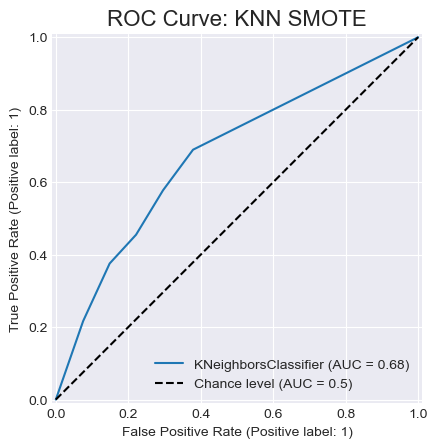

In [181]:
knn_model_smote = model(estimator=knn, name='KNN SMOTE', 
                        xtrain=X_train_smote, ytrain=y_train_smote)

### KNN OVERSAMPLING

[[3744  605]
 [ 193   84]]
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      4349
           1       0.12      0.30      0.17       277

    accuracy                           0.83      4626
   macro avg       0.54      0.58      0.54      4626
weighted avg       0.90      0.83      0.86      4626

Model Accuracy: 0.827,
    Precision: 0.122,
    Recall: 0.303,
    F1 Score: 0.174




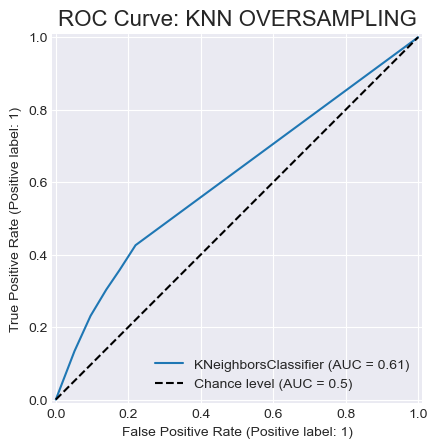

In [182]:
knn_model_over = model(estimator=knn, name='KNN OVERSAMPLING', 
                       xtrain=X_train_over, ytrain=y_train_over)

### KNN UNDERSAMPLING

[[2581 1768]
 [  79  198]]
              precision    recall  f1-score   support

           0       0.97      0.59      0.74      4349
           1       0.10      0.71      0.18       277

    accuracy                           0.60      4626
   macro avg       0.54      0.65      0.46      4626
weighted avg       0.92      0.60      0.70      4626

Model Accuracy: 0.601,
    Precision: 0.101,
    Recall: 0.715,
    F1 Score: 0.177




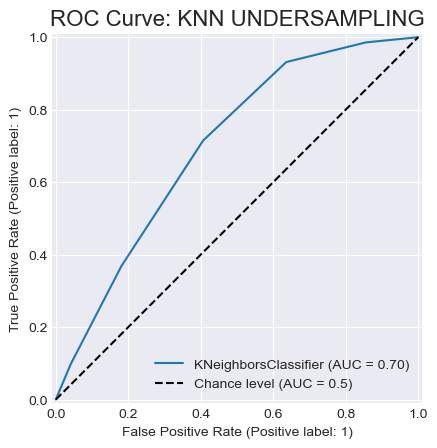

In [183]:
knn_model_under = model(estimator=knn, name='KNN UNDERSAMPLING', 
                        xtrain=X_train_under, ytrain=y_train_under)

## XGBOOST:
Fit an XGBOOST model to each of the train sets (SMOTE, OVERSAMPLING, & UNDERSAMPLING)

In [184]:
xgb = XGBClassifier(random_state=random_seed)
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=49, ...)

### XGBOOST SMOTE

[[4309   40]
 [ 260   17]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      4349
           1       0.30      0.06      0.10       277

    accuracy                           0.94      4626
   macro avg       0.62      0.53      0.53      4626
weighted avg       0.90      0.94      0.91      4626

Model Accuracy: 0.935,
    Precision: 0.298,
    Recall: 0.061,
    F1 Score: 0.102




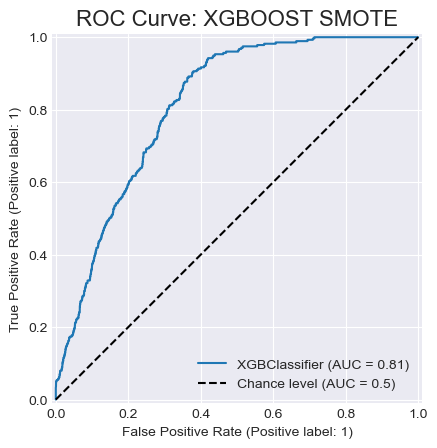

In [185]:
xgb_model_smote = model(estimator=xgb, name='XGBOOST SMOTE', 
                        xtrain=X_train_smote, ytrain=y_train_smote)

### XGBOOST OVERSAMPLING

[[3795  554]
 [ 180   97]]
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      4349
           1       0.15      0.35      0.21       277

    accuracy                           0.84      4626
   macro avg       0.55      0.61      0.56      4626
weighted avg       0.91      0.84      0.87      4626

Model Accuracy: 0.841,
    Precision: 0.149,
    Recall: 0.35,
    F1 Score: 0.209




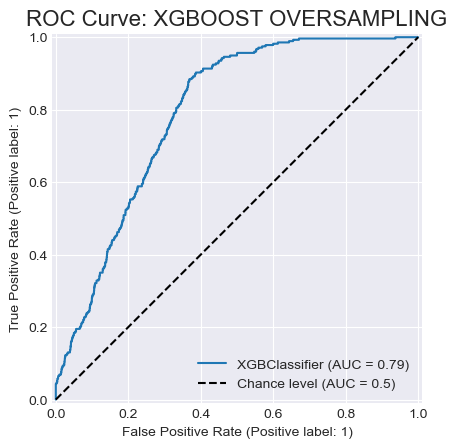

In [186]:
xgb_model_over = model(estimator=xgb, name='XGBOOST OVERSAMPLING', 
                       xtrain=X_train_over, ytrain=y_train_over)

### XGBOOST UNDERSAMPLING

[[2948 1401]
 [  72  205]]
              precision    recall  f1-score   support

           0       0.98      0.68      0.80      4349
           1       0.13      0.74      0.22       277

    accuracy                           0.68      4626
   macro avg       0.55      0.71      0.51      4626
weighted avg       0.93      0.68      0.77      4626

Model Accuracy: 0.682,
    Precision: 0.128,
    Recall: 0.74,
    F1 Score: 0.218




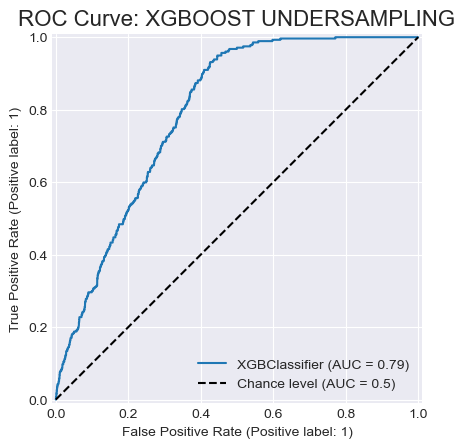

In [187]:
xgb_model_under = model(estimator=xgb, name='XGBOOST UNDERSAMPLING', 
                        xtrain=X_train_under, ytrain=y_train_under)

## Getting the Best Models

The models with the best metrics for each of XGBOOST and KNN would be selected and then tuned

In [188]:
all_models = [knn_model_smote, knn_model_over, knn_model_under, 
              xgb_model_smote, xgb_model_over, xgb_model_under]

# Convert results to a DataFrame
results_df = pd.DataFrame(all_models, 
                          columns=['Model', 'Name', 'Accuracy', 
                                   'Precision', 'Recall', 'F1 Score'])

#sort the models based on the best Recall and F1 score
results_df = results_df.sort_values(by='F1 Score', ascending=False)

# Display the results DataFrame for comparison
results_df.drop('Model', axis=1)

,Name,Accuracy,Precision,Recall,F1 Score
5,XGBOOST UNDERSAMPLING,0.681582,0.127646,0.740072,0.217738
4,XGBOOST OVERSAMPLING,0.841332,0.149002,0.350181,0.209052
0,KNN SMOTE,0.759187,0.115702,0.454874,0.184480
2,KNN UNDERSAMPLING,0.600735,0.100712,0.714801,0.176549
1,KNN OVERSAMPLING,0.827497,0.121916,0.303249,0.173913
3,XGBOOST SMOTE,0.935149,0.298246,0.061372,0.101796


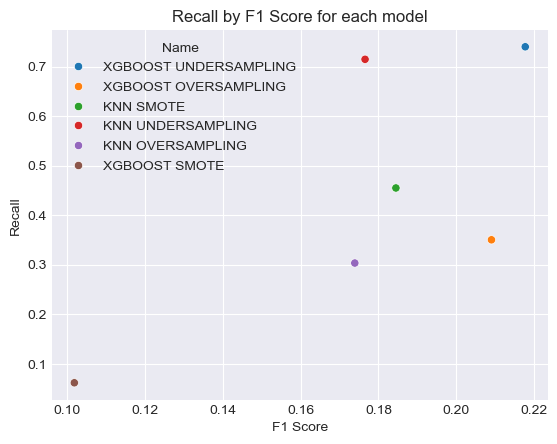

In [189]:
# plot the results and identify the best model 
sns.scatterplot(x='F1 Score', y='Recall', data=results_df, hue='Name')
plt.title('Recall by F1 Score for each model')
plt.show()

XGBOOST Undersampling has the best recall and f1 score.

KNN SMOTE has higher f1 score, but KNN undersampling has much higher recall, and a similar f1 score

### Hyperparameter Tuning for KNN
To improve the performance of the default KNN model, we tune these hyperparameters:
- **n_neighbors**:  Controls the number of neighbors
- **weights**: Controls how the neighbors are weighted
- **metric**: The distance metric used to calculate the distance between data points

In [190]:
# Tuning Hyperparameters
params_knn = {
    'n_neighbors': np.arange(2,8,1),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# Apply GridSearchCV
knn_grid = GridSearchCV(estimator=knn, param_grid=params_knn, 
                        scoring='recall', cv=5, n_jobs=-1, verbose=1)
# fit on undersampling train set
knn_grid.fit(X_train_under, y_train_under)
# get the best hyperparameters
knn_grid.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}

In [191]:
best_knn = knn_grid.best_estimator_
best_knn

KNeighborsClassifier(metric='manhattan', n_jobs=1, n_neighbors=7)

In [192]:
# fit the estimator to the train set
best_knn.fit(X_train_under, y_train_under)

# predict on the test set
y_pred_knn = best_knn.predict(X_test_fs)

In [193]:
# Calculate the accuracy of the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Calculate the precision, recall, and f1-score
precision_knn = round(precision_score(y_test, y_pred_knn),2)
recall_knn = round(recall_score(y_test, y_pred_knn),2)
f1_knn = round(f1_score(y_test, y_pred_knn),2)

# Calculate the AUC
AUC_knn = round(roc_auc_score(y_test, best_knn.predict_proba(X_test_fs)[:, 1]),2)

In [194]:
# print out the results
final_knn = [recall_knn, f1_knn, precision_knn, AUC_knn]
metrics_knn = ['Recall','F1 Score', 'Precision',  'ROC_AUC %']
knn_df = pd.DataFrame(dict(zip(metrics_knn,final_knn)), index=['KNN Classsifier'])
knn_df

,Recall,F1 Score,Precision,ROC_AUC %
KNN Classsifier,0.68,0.18,0.1,0.72


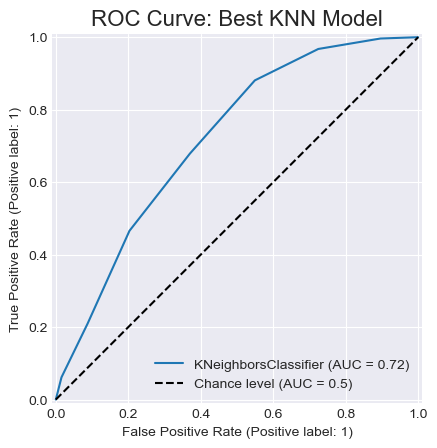

In [195]:
# Plot AUC-ROC
RocCurveDisplay.from_estimator(estimator=best_knn, X=X_test_fs, y=y_test, plot_chance_level=True)
plt.title('ROC Curve: Best KNN Model', fontsize=16)
plt.show()

In [196]:
# create the confusion matrix in a df 
conf_matrix_knn = pd.DataFrame(data=confusion_matrix(y_test, y_pred_knn), 
                               columns=['Prediction: No Fraud', 'Prediction: Fraud'],
                               index=['Actual: No Fraud', 'Actual: Fraud'])

print("                    KNN CONFUSION MATIRX")
conf_matrix_knn

                    KNN CONFUSION MATIRX


,Prediction: No Fraud,Prediction: Fraud
Actual: No Fraud,2740,1609
Actual: Fraud,89,188


In [197]:
# print classification report
print("               KNN CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred_knn))

               KNN CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.97      0.63      0.76      4349
           1       0.10      0.68      0.18       277

    accuracy                           0.63      4626
   macro avg       0.54      0.65      0.47      4626
weighted avg       0.92      0.63      0.73      4626



### Hyperparameter Tuning for XGBoost
To improve the performance of the default XGBOOST model, we tune these hyperparameters:
- **n_estimators**:  Controls the number of boosting rounds
- **max_depth**: Controls the maximum depth of each tree
- **eta**: Controls the learning rate of the model
- **scale_pos_weight**: Controls the class weights


In [198]:
# Tuning Hyperparamters
params_xgb = {
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 4, 5],
    'eta': [0.001, 0.01, 0.1],
    'scale_pos_weight': [2, 3, 4]
}

# Apply GridSearchCV
xgb_grid = GridSearchCV(estimator=xgb, param_grid=params_xgb, 
                        scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
# fit on undersampling train set
xgb_grid.fit(X_train_under, y_train_under)
# get the best hyperparameters
xgb_grid.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


{'eta': 0.01, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 2}

In [199]:
# create the optimal xgboost model with the best parameters from the gridsearch
optimal_model = xgb_grid.best_estimator_
optimal_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [200]:
# fit the estimator to the train set
optimal_model.fit(X_train_under, y_train_under)

# predict on the test set
y_pred = optimal_model.predict(X_test_fs)

In [201]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Calculate the precision, recall, and f1-score
precision = round(precision_score(y_test, y_pred),2)
recall = round(recall_score(y_test, y_pred),2)
f1 = round(f1_score(y_test, y_pred),2)

# Calculate the AUC
AUC = round(roc_auc_score(y_test, optimal_model.predict_proba(X_test_fs)[:, 1]),2)

In [202]:
# print out the results
final = [recall, f1, precision, AUC]
metrics = ['Recall','F1 Score', 'Precision',  'ROC_AUC %']
xgb_df = pd.DataFrame(dict(zip(metrics,final)), index=['XGBOOST Classsifier'])
xgb_df

,Recall,F1 Score,Precision,ROC_AUC %
XGBOOST Classsifier,0.97,0.23,0.13,0.82


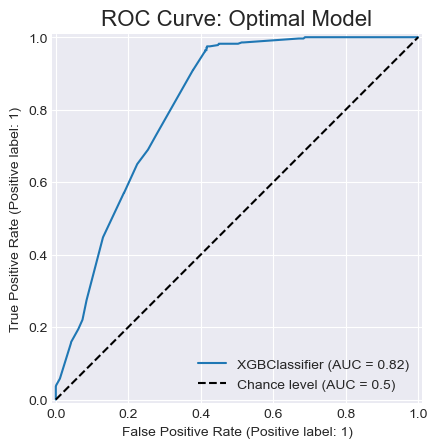

In [203]:
# Plot AUC-ROC
RocCurveDisplay.from_estimator(estimator=optimal_model, X=X_test_fs, y=y_test, plot_chance_level=True)
plt.title('ROC Curve: Optimal Model', fontsize=16)
plt.show()

In [204]:
# create the confusion matrix in a df 
conf_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_pred), 
                           columns=['Prediction: No Fraud', 'Prediction: Fraud'],
                           index=['Actual: No Fraud', 'Actual: Fraud'])

print("                    XGBOOST CONFUSION MATRIX")
conf_matrix

                    XGBOOST CONFUSION MATRIX


,Prediction: No Fraud,Prediction: Fraud
Actual: No Fraud,2541,1808
Actual: Fraud,8,269


In [205]:
# print classification report
print("               XGBOOST CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))

               XGBOOST CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.58      0.74      4349
           1       0.13      0.97      0.23       277

    accuracy                           0.61      4626
   macro avg       0.56      0.78      0.48      4626
weighted avg       0.94      0.61      0.71      4626



## Comparing Results

In [206]:
# create the confusion matrix in a df 
conf_matrix_knn = pd.DataFrame(data=confusion_matrix(y_test, y_pred_knn), 
                               columns=['Prediction: No Fraud', 'Prediction: Fraud'],
                               index=['Actual: No Fraud', 'Actual: Fraud'])

print("                    KNN CONFUSION MATIRX")
conf_matrix_knn

                    KNN CONFUSION MATIRX


,Prediction: No Fraud,Prediction: Fraud
Actual: No Fraud,2740,1609
Actual: Fraud,89,188


In [207]:
# create the confusion matrix in a df 
conf_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_pred), 
                           columns=['Prediction: No Fraud', 'Prediction: Fraud'],
                           index=['Actual: No Fraud', 'Actual: Fraud'])

print("                    XGBOOST CONFUSION MATRIX")
conf_matrix

                    XGBOOST CONFUSION MATRIX


,Prediction: No Fraud,Prediction: Fraud
Actual: No Fraud,2541,1808
Actual: Fraud,8,269


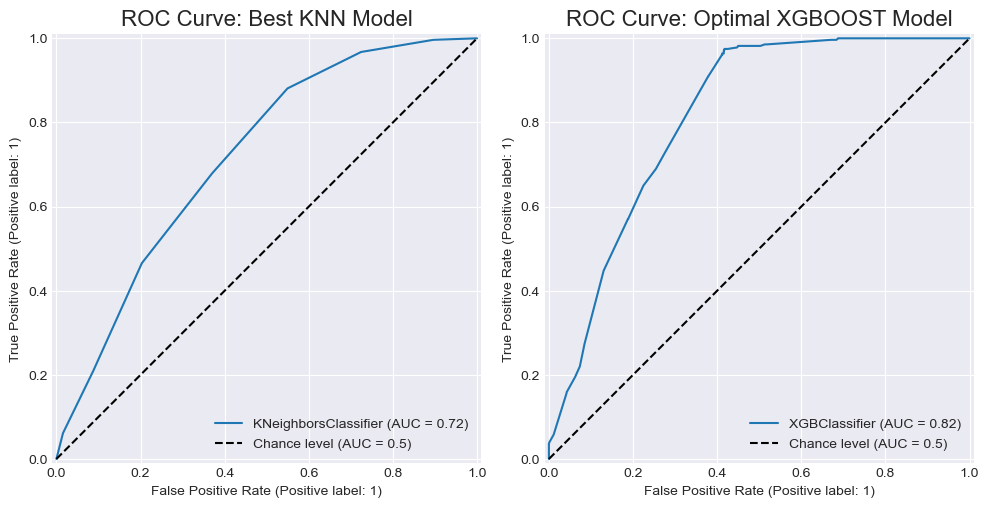

In [208]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
# Plot AUC-ROC for both models
RocCurveDisplay.from_estimator(estimator=best_knn, X=X_test_fs, y=y_test, ax=ax[0], plot_chance_level=True)
RocCurveDisplay.from_estimator(estimator=optimal_model, X=X_test_fs, y=y_test, ax=ax[1], plot_chance_level=True)
ax[0].set_title('ROC Curve: Best KNN Model', fontsize=16)
ax[1].set_title('ROC Curve: Optimal XGBOOST Model', fontsize=16)
plt.tight_layout()
plt.show()

In [209]:
# Results for both models
pd.concat([knn_df, xgb_df], axis=0)

,Recall,F1 Score,Precision,ROC_AUC %
KNN Classsifier,0.68,0.18,0.10,0.72
XGBOOST Classsifier,0.97,0.23,0.13,0.82


XGBOOST IS THE BEST MODEL

## Feature Importance - XGBOOST

In [210]:
# create the list of importances and features
importances = list(optimal_model.feature_importances_)
features = selected_features
features

array(['scaler__Age', 'ordinal__VehiclePrice', 'ordinal__Deductible',
       'ordinal__DriverRating', 'ordinal__Days_Policy_Accident',
       'ordinal__PastNumberOfClaims', 'ordinal__AgeOfVehicle',
       'ordinal__NumberOfSuppliments', 'ordinal__AddressChange_Claim',
       'ordinal__NumberOfCars', 'nominal__AccidentArea_Urban',
       'nominal__Sex_Male', 'nominal__Fault_Third Party',
       'nominal__PoliceReportFiled_Yes', 'nominal__Make_Chevrolet',
       'nominal__Make_Ford', 'nominal__Make_Honda', 'nominal__Make_Mazda',
       'nominal__Make_Pontiac', 'nominal__Make_Saab',
       'nominal__Make_Toyota', 'nominal__MaritalStatus_Married',
       'nominal__MaritalStatus_Single', 'nominal__VehicleCategory_Sport',
       'nominal__VehicleCategory_Utility',
       'nominal__BasePolicy_Collision', 'nominal__BasePolicy_Liability'],
      dtype=object)

In [211]:
# replace scaler__, nominal__, and ordinal__ with '' 
features = [col.replace('scaler__', '') for col in features]
features = [col.replace('nominal__', '') for col in features]
features = [col.replace('ordinal__', '') for col in features]
features

['Age',
 'VehiclePrice',
 'Deductible',
 'DriverRating',
 'Days_Policy_Accident',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'NumberOfSuppliments',
 'AddressChange_Claim',
 'NumberOfCars',
 'AccidentArea_Urban',
 'Sex_Male',
 'Fault_Third Party',
 'PoliceReportFiled_Yes',
 'Make_Chevrolet',
 'Make_Ford',
 'Make_Honda',
 'Make_Mazda',
 'Make_Pontiac',
 'Make_Saab',
 'Make_Toyota',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'VehicleCategory_Sport',
 'VehicleCategory_Utility',
 'BasePolicy_Collision',
 'BasePolicy_Liability']

In [212]:
# create the feature importance df
feature_importance_df = pd.DataFrame({'Features':features, 'Importances':importances}).sort_values(by='Importances', ascending=False)
feature_importance_df.head(10)

,Features,Importances
26,BasePolicy_Liability,0.331932
12,Fault_Third Party,0.257069
2,Deductible,0.228610
8,AddressChange_Claim,0.051104
25,BasePolicy_Collision,0.027029
1,VehiclePrice,0.026628
0,Age,0.018682
6,AgeOfVehicle,0.017793
20,Make_Toyota,0.010848
15,Make_Ford,0.009193


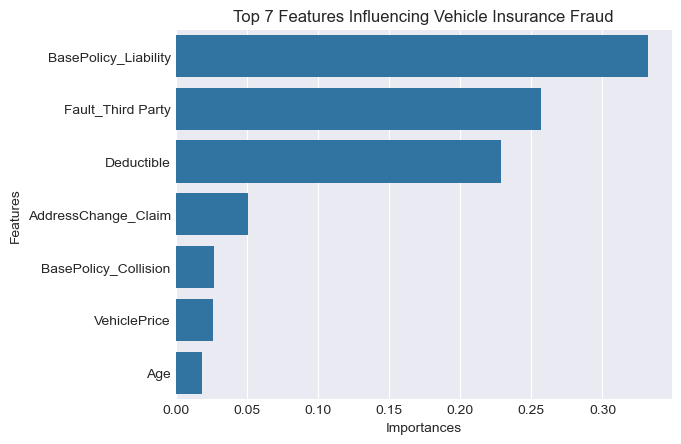

In [213]:
# plot the feature importances
sns.barplot(data=feature_importance_df.head(7), x='Importances', y='Features')
plt.title('Top 7 Features Influencing Vehicle Insurance Fraud')
# save it as a png file
plt.savefig('feature_importance.png', bbox_inches='tight')
plt.show()